# Predicting flood occurrence
Flood occurrences in downtown Norfolk are predicted based on rain, tide levels, water table levels, and wind speed/direction. 

In [1]:
repo = "http://cran.us.r-project.org"
library(caret)
library(ggfortify)
library(ggplot2)
library(dplyr)
library(rpart)
library(rpart.plot)
library(RSQLite)
library(DBI)
library(randomForest)
library(e1071)
library(class)

Warning message:
"package 'caret' was built under R version 3.3.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'ggfortify' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'rpart.plot' was built under R version 3.3.3"Warning message:
"package 'RSQLite' was built under R version 3.3.3"Warning message:
"package 'DBI' was built under R version 3.3.3"Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The followin

In [2]:
classify_knn = function(pca.data, obs_data, point, k){
  neighs = get_nn(pca.data, point, k)
  neigh_data = obs_data[neighs,]
  return(names(which.max(table(neigh_data$fld))))
}

In [3]:
get_nn = function(d, point, k){
  point = d[point, ]
  dists = sort(sqrt(rowSums((t(t(d) - point))^2)))
  close_points = names(dists)[2:k]
  return(close_points)
}

In [4]:
base_dir<- "C:/Users/Jeff/Documents/research/Sadler_3rdPaper/manuscript/"
data_dir<- "C:/Users/Jeff/Google Drive/research/Sadler_3rdPaper_Data/"
fig_dir <- paste(base_dir, "Figures/general/", sep="")
db_filename <- "floodData.sqlite"

In [5]:
con = dbConnect(RSQLite::SQLite(), dbname=paste(data_dir, db_filename, sep=""))

In [6]:
df = dbReadTable(con, 'flood_locations')

In [7]:
colnames(df)

[1] "index"      "location"   "xcoord"     "ycoord"     "count"     
 [6] "twi"        "elev_1"     "dist_to_ba" "imp"        "dist_to_wa"
[11] "is_dntn"    "in_hague"   "Structure1" "Rim_Elevat" "Invert_Ele"
[16] "Year_Insta" "Pipe_Geome" "Horizontal" "Vertical_D" "Pipe_Lengt"
[21] "Pipe_Mater" "Year_Ins_1" "Condition"  "flood_pt"

In [8]:
in_col_names = c('elev_1',
                 #'dist_to_ba',
                 'imp',
                 'dist_to_wa',
                 'Structure1',
                 'twi',
                 'Rim_Elevat',
                 'Invert_Ele',
                 'Year_Insta',
                 'Pipe_Geome',
                 'Horizontal',                 
                 'Vertical_D',
                 'Pipe_Lengt',
                 'Pipe_Mater',
                 'Vertical_D'
                )
out_col_name = 'flood_pt'
model_data = df[, c(in_col_names, out_col_name)]
model_data[,out_col_name] = model_data[,out_col_name]>0
model_data[,out_col_name] = factor(model_data[,out_col_name])

In [9]:
model_data = na.omit(model_data)

In [10]:
model_data$Structure1 = as.factor(model_data$Structure1)
model_data$Pipe_Geome = as.factor(model_data$Structure1)
model_data$Pipe_Mater = as.factor(model_data$Structure1)

In [11]:
head(model_data)

elev_1,imp,dist_to_wa,Structure1,twi,Rim_Elevat,Invert_Ele,Year_Insta,Pipe_Geome,Horizontal,Vertical_D,Pipe_Lengt,Pipe_Mater,Vertical_D.1,flood_pt
0.663456,74738,353.265,CBNS,7.48559,4.33,2.42,1938,CBNS,9,14,25,CBNS,14,TRUE
0.641102,78962,354.661,CBNS,7.53130,4.34,1.85,1938,CBNS,11,18,25,CBNS,18,TRUE
0.877023,90165,505.969,CBNS,8.72800,4.98,1.21,1938,CBNS,24,0,240,CBNS,0,TRUE
0.975468,87607,357.142,CBNS,7.75242,5.59,3.28,1938,CBNS,15,0,30,CBNS,0,TRUE
1.023950,92306,612.997,YB,9.70383,4.96,3.10,1938,YB,12,0,50,YB,0,TRUE
1.230800,100599,639.295,CBNS,4.76609,5.70,3.02,1938,CBNS,15,0,55,CBNS,0,TRUE


In [12]:
print(summary(model_data[,out_col_name]))
sum(as.numeric(model_data[,out_col_name] == TRUE))/sum(as.numeric(model_data[,out_col_name] == FALSE))

FALSE  TRUE 
  682   680 


[1] 0.9970674

### Partition data into training and testing sets

In [13]:
prt = createDataPartition(model_data[, out_col_name], p=0.7)
train_ind = prt$Resample1
test_ind = rownames(model_data[-train_ind,])
print(length(test_ind) + length(train_ind))
# length(rownames(model_data[model_data[train_ind, out_col_name]==TRUE]))
length(test_ind)

[1] 1362


[1] 408

In [14]:
train_data = model_data[train_ind, ]
test_data = model_data[test_ind, ]

In [15]:
tst_out = model_data[test_ind, out_col_name]
trn_out = model_data[train_ind, out_col_name]

### Downsample negative records in training dataset

In [16]:
nfld_train = rownames(train_data[train_data[, out_col_name] == FALSE,])
fld_train = rownames(train_data[train_data[, out_col_name] == TRUE,])
nfld_test = rownames(test_data[test_data[, out_col_name] == FALSE,])
fld_test = rownames(test_data[test_data[, out_col_name] == TRUE,])
down_sample_percent = 1
nfld_train_dwnsmp = sample(nfld_train, down_sample_percent*length(nfld_train))
train_ind = c(fld_train, nfld_train_dwnsmp)

In [17]:
train_in_data = model_data[train_ind, in_col_names]
test_in_data = model_data[test_ind, in_col_names]

### Decision Trees

In [18]:
dt_fmla = as.formula(paste(out_col_name, "~", paste(in_col_names, collapse="+")))
dt_train_data = model_data[train_ind, ]
dt_test_data = model_data[test_ind, in_col_names]

In [19]:
fit = rpart(dt_fmla, method='class', data=dt_train_data, minsplit=2)
printcp(fit)


Classification tree:
rpart(formula = dt_fmla, data = dt_train_data, method = "class", 
    minsplit = 2)

Variables actually used in tree construction:
[1] elev_1     Horizontal twi        Year_Insta

Root node error: 476/954 = 0.49895

n= 954 

        CP nsplit rel error  xerror     xstd
1 0.344538      0   1.00000 1.10504 0.032273
2 0.026261      1   0.65546 0.66176 0.030516
3 0.016807      3   0.60294 0.69958 0.030930
4 0.012605      5   0.56933 0.70798 0.031015
5 0.010000      7   0.54412 0.69328 0.030865


png 
  2

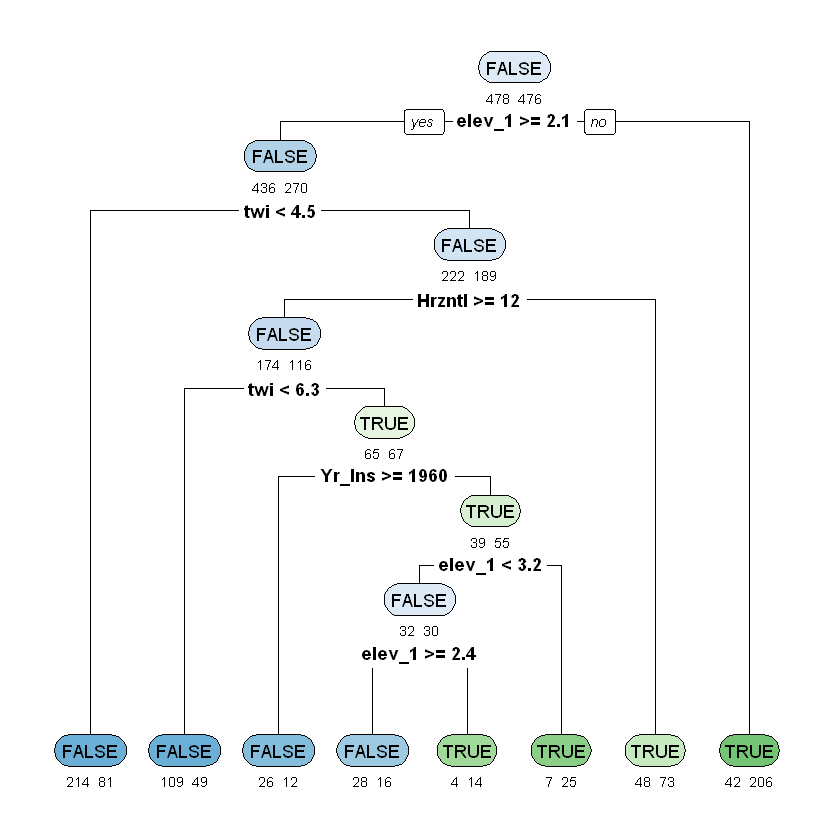

In [20]:
tiff(paste(fig_dir, "Plot2.tif"), width=9, height=6, units='in', res = 300)
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)
dev.off()
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)

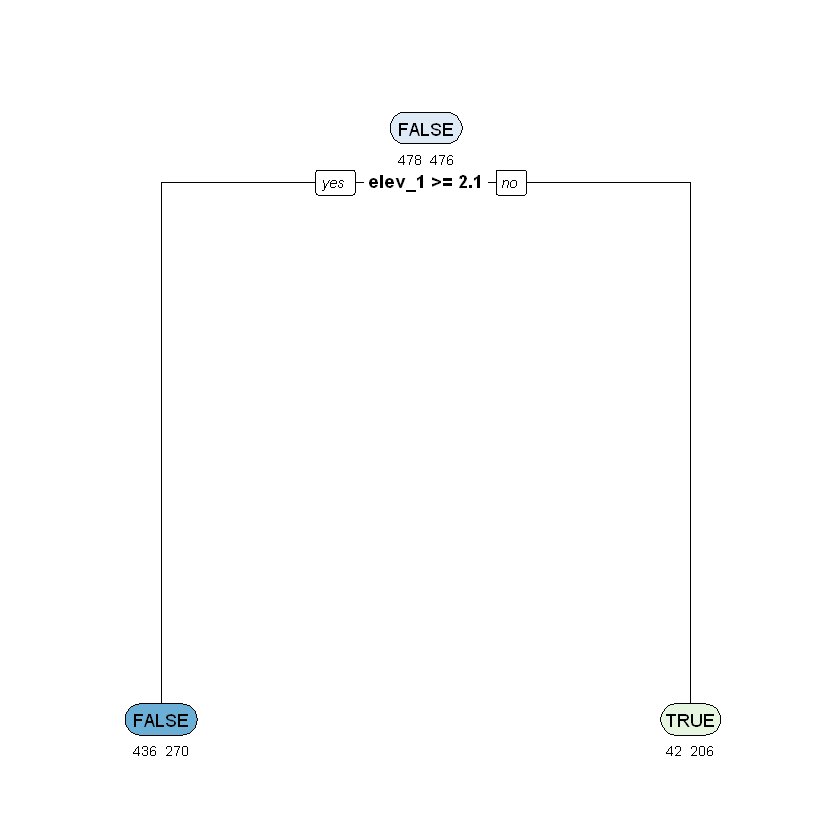

In [21]:
pfit<- prune(fit, cp=fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
rpart.plot(pfit, under=TRUE, cex=0.9, extra=1, varlen = 6)

#### Decision Tree training results

In [22]:
pred = predict(pfit, dt_train_data[, in_col_names], type = 'class')
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   344  134
  TRUE    362  114

#### Decision Tree testing results

In [23]:
pred = predict(pfit, dt_test_data, type = 'class')
table(tst_out, pred)

       pred
tst_out FALSE TRUE
  FALSE   183   21
  TRUE    114   90

### Random Forests

In [24]:
forest = randomForest(dt_fmla, data = dt_train_data, importance = TRUE, type="classification", nodesize=2)

pred = predict(forest, dt_train_data[, in_col_names])
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   238  240
  TRUE    240  236

In [25]:
pred = predict(forest, dt_test_data)
table(tst_out, pred)
forest$importance

       pred
tst_out FALSE TRUE
  FALSE   141   63
  TRUE     66  138

,FALSE,TRUE,MeanDecreaseAccuracy,MeanDecreaseGini
elev_1,0.0590228369,0.0609389934,0.0597990959,82.455673
imp,0.0079152738,0.0032070296,0.0054772905,44.584663
dist_to_wa,0.0146031282,0.0036806974,0.0090934900,44.909518
Structure1,0.0040550813,-0.0020362251,0.0009892954,7.786978
twi,0.0183895808,0.0173631934,0.0177758574,57.010807
Rim_Elevat,0.0458630269,0.0234558698,0.0345140910,61.121803
Invert_Ele,0.0238477268,0.0166281282,0.0201298773,50.512537
Year_Insta,0.0140595525,0.0001849446,0.0070894052,31.851118
Pipe_Geome,0.0051208034,-0.0013883300,0.0018236917,8.336899
Horizontal,0.0020480442,0.0065362085,0.0042884125,19.761517


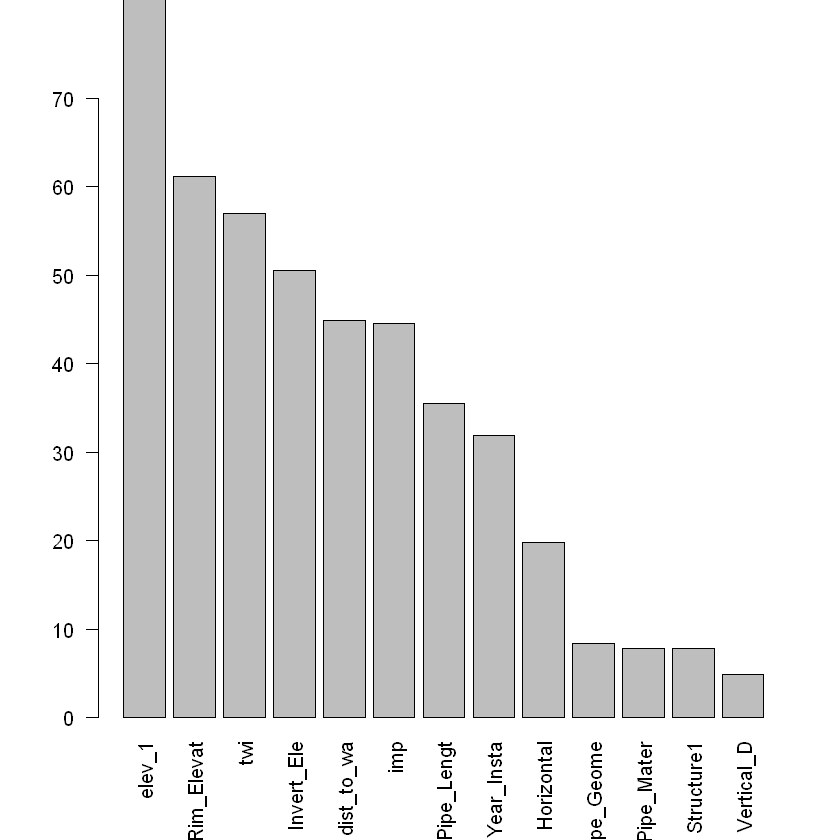

In [26]:
impo = as.data.frame(forest$importance)
impo = impo[order(-impo$MeanDecreaseGini),]
par(las=2)
barplot(impo$MeanDecreaseGini, names.arg=rownames(impo), ylim = c(0, 70))